In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import math

import random

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

M = 1000
batch_size = 256
epochs = 5
lr = 0.001

In [10]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x)),
    transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x)),
    transforms.Lambda(lambda x : x + math.sqrt(1)*torch.randn_like(x)), 
    transforms.Lambda(lambda x : x)
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
total_train = len(train_dataset)  # 60,000 for MNIST

# Generate a list of shuffled indices
all_indices = list(range(total_train))
random.shuffle(all_indices)

# Split indices into labeled and unlabeled
labeled_indices = all_indices[:M]
unlabeled_indices = all_indices[M:]

# Create datasets
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

labeled_loader = DataLoader(dataset=labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
        self.bn7 = nn.BatchNorm2d(512)
        self.bn8 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input):
        c1 = F.relu(self.bn1(self.conv1(input)))
        s1 = F.max_pool2d(c1, (2, 2))
        c2 = F.relu(self.bn2(self.conv2(s1)))
        s2 = F.max_pool2d(c2, (2, 2))
        c3 = F.relu(self.bn3(self.conv3(s2)))
        c4 = F.relu(self.bn4(self.conv4(c3)))
        s4 = F.max_pool2d(c4, (2, 2))
        c5 = F.relu(self.bn5(self.conv5(s4)))
        c6 = F.relu(self.bn6(self.conv6(c5)))
        s6 = F.max_pool2d(c6, (2, 2))
        c7 = F.relu(self.bn7(self.conv7(s6)))
        c8 = F.relu(self.bn8(self.conv8(c7)))
        s8 = F.max_pool2d(c8, (2, 2))

        s8 = torch.flatten(s8, 1)

        f1 = F.relu(self.fc1(s8))
        d1 = self.dropout(f1)
        f2 = F.relu(self.fc2(d1))
        d2 = self.dropout(f2)
        output = self.fc3(d2)

        return output

In [12]:
def train(model, labeled_loader, unlabeled_loader, criterion, device, alpha=1.0):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    running_loss = 0.0
    correct = 0
    total = 0.0

    # Iterate over both labeled and unlabeled data
    for (labeled_batch, unlabeled_batch) in zip(labeled_loader, unlabeled_loader):
        # Labeled data
        x_l, y_l = labeled_batch
        x_l, y_l = x_l.to(device), y_l.to(device)

        # Unlabeled data
        x_u, _ = unlabeled_batch
        x_u = x_u.to(device)

        # --- Forward ---
        outputs_l = model(x_l)
        loss_sup = criterion(outputs_l, y_l) * y_l.size(0)

        # --- Unsupervised loss: consistency example ---
        with torch.no_grad():
            pseudo_labels = model(x_u).detach()

        outputs_aug = model(x_u)

        # KL divergence between pseudo labels and augmented predictions
        prob_pseudo = torch.softmax(pseudo_labels, dim=1)
        log_prob_aug = torch.log_softmax(outputs_aug, dim=1)
        loss_unsup = F.kl_div(log_prob_aug, prob_pseudo, reduction='batchmean')

        # --- Combine losses ---
        total_loss = loss_sup + alpha * loss_unsup

        # --- Backward + optimize ---
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Track stats ---
        running_loss += total_loss.item()
        _, predicted = torch.max(outputs_l, 1)
        correct += (predicted == y_l).sum().item()
        total += y_l.size(0)

    return running_loss / total, correct / total

In [13]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    loss, acc = train(model, labeled_loader, unlabeled_loader, criterion, device)
    train_loss.append(loss)
    train_acc.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss * 100:.2f}%, Train Accuracy: {acc * 100:.2f}%")
    loss, acc = test(model, test_loader, criterion, device)
    test_loss.append(loss)
    test_acc.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Test Loss: {loss * 100:.2f}%, Test Accuracy: {acc * 100:.2f}%")

NameError: name 'augment' is not defined

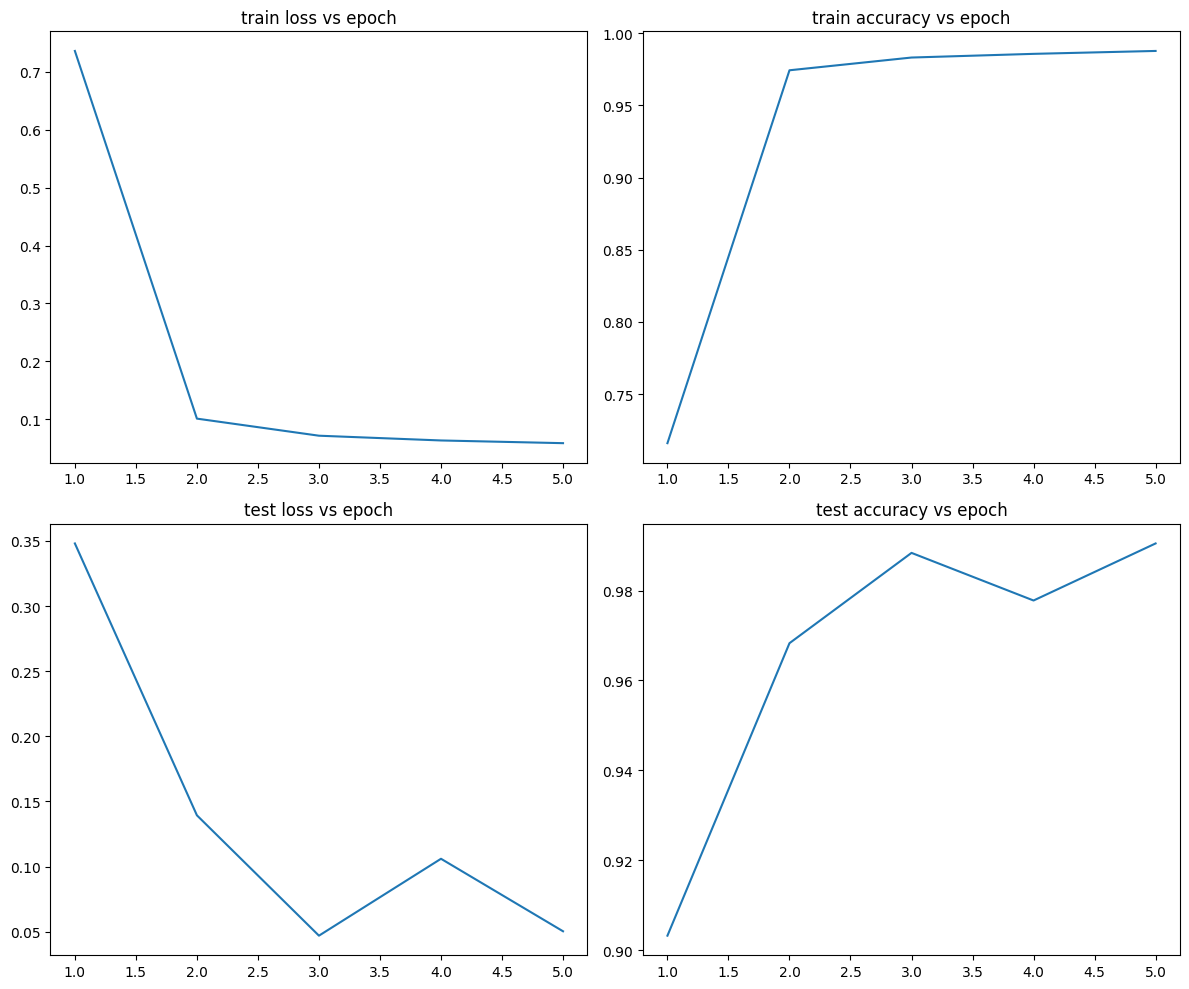

In [40]:
plt.figure(figsize = (12,10))

plt.subplot(221)
plt.plot(range(1, epochs + 1), train_loss)
plt.title("train loss vs epoch")

plt.subplot(222)
plt.plot(range(1, epochs + 1), train_acc)
plt.title("train accuracy vs epoch")

plt.subplot(223)
plt.plot(range(1, epochs + 1), test_loss)
plt.title("test loss vs epoch")

plt.subplot(224)
plt.plot(range(1, epochs + 1), test_acc)
plt.title("test accuracy vs epoch")

plt.tight_layout()
plt.show()

In [43]:
noise_level = [0.01, 0.1, 1]

def test_gaussian(model, test_loader, criterion, device, noise_level):
    transform = transforms.Compose([transforms.Resize((32, 32)), 
                                    transforms.ToTensor(), 
                                    transforms.Lambda(lambda x : x + math.sqrt(noise_level)*torch.randn_like(x))])
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    _, acc = test(model, test_loader, criterion, device)
    return acc
gaussian_acc = []
for noise in noise_level:
    acc = test_gaussian(model, test_loader, criterion, device, noise)
    gaussian_acc.append(acc)
    print(f"Noise level: {noise}, Accuracy: {acc * 100:.2f}%")

Noise level: 0.01, Accuracy: 99.03%
Noise level: 0.1, Accuracy: 75.69%
Noise level: 1, Accuracy: 16.14%


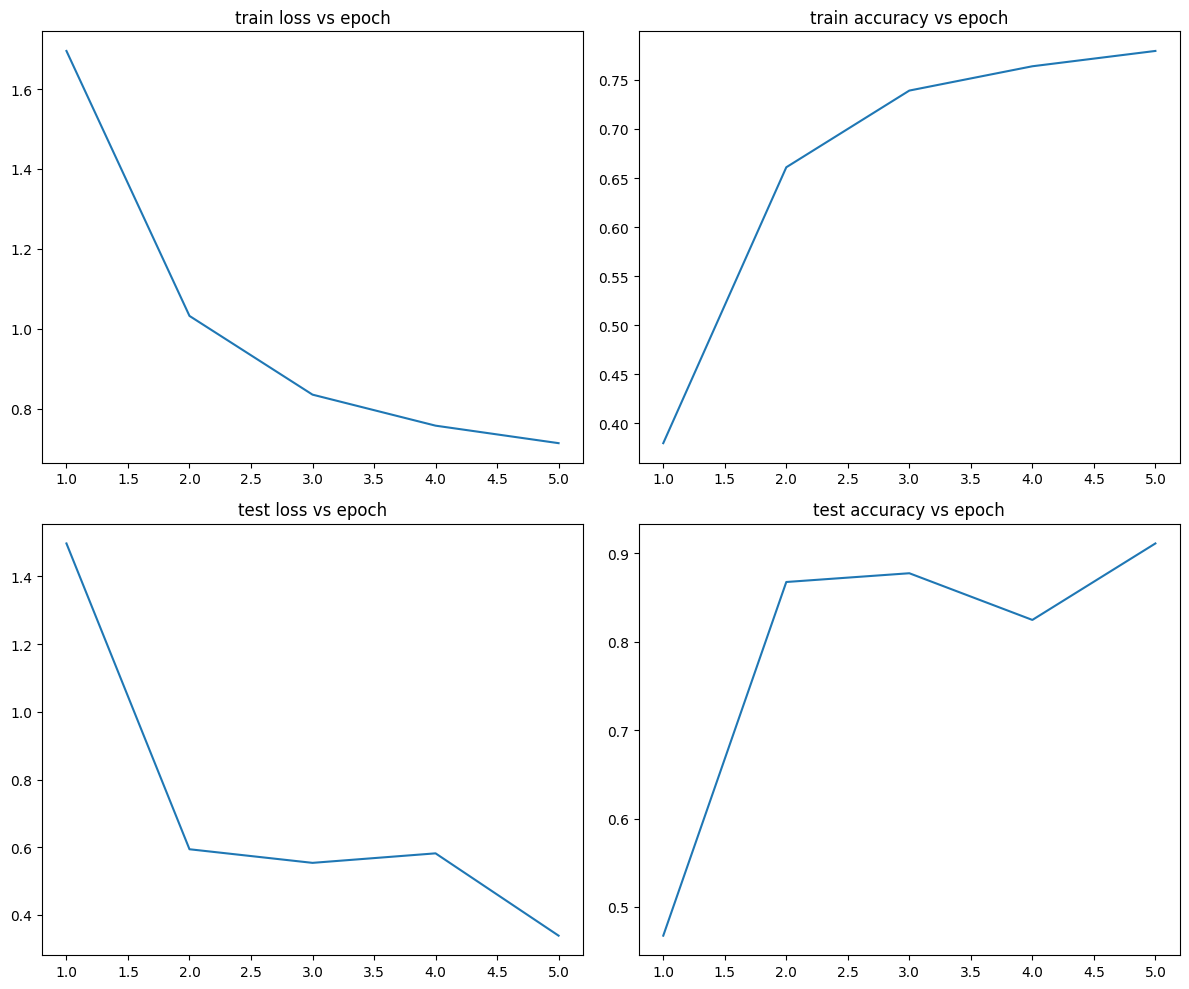

In [47]:
plt.figure(figsize = (12,10))

plt.subplot(221)
plt.plot(range(1, epochs + 1), train_loss_aug)
plt.title("train loss vs epoch")

plt.subplot(222)
plt.plot(range(1, epochs + 1), train_acc_aug)
plt.title("train accuracy vs epoch")

plt.subplot(223)
plt.plot(range(1, epochs + 1), test_loss_aug)
plt.title("test loss vs epoch")

plt.subplot(224)
plt.plot(range(1, epochs + 1), test_acc_aug)
plt.title("test accuracy vs epoch")

plt.tight_layout()
plt.show()

In [48]:
_, acc_h = test(model_aug, test_loader_h, criterion, device)
print(f"Horizontal Flip Accuracy: {acc_h * 100:.2f}%")

_, acc_v = test(model_aug, test_loader_v, criterion, device)
print(f"Vertical Flip Accuracy: {acc_v * 100:.2f}%")

Horizontal Flip Accuracy: 86.81%
Vertical Flip Accuracy: 81.17%


In [50]:
gaussian_acc = []
for noise in noise_level:
    acc = test_gaussian(model_aug, test_loader, criterion, device, noise)
    gaussian_acc.append(acc)
    print(f"Noise level: {noise}, Accuracy: {acc * 100:.2f}%")

Noise level: 0.01, Accuracy: 91.92%
Noise level: 0.1, Accuracy: 92.97%
Noise level: 1, Accuracy: 85.42%


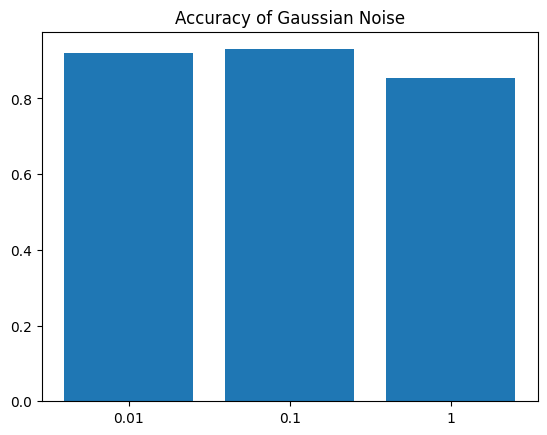

In [51]:
plt.bar(["0.01", "0.1", "1"], gaussian_acc)
plt.title("Accuracy of Gaussian Noise")
plt.show()